In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
cred = pd.read_parquet('../data/credit_history.parquet', engine="fastparquet")
xml = pd.read_xml('../data/geographic_data.xml')
xlsx = pd.read_excel('../data/loan_details.xlsx')
jsonl = pd.read_json('../data/financial_ratios.jsonl', lines=True)
demog = pd.read_csv('../data/demographics.csv')
appl = pd.read_csv('../data/application_metadata.csv')

In [33]:
dfs = [cred, xml, xlsx, jsonl, demog, appl]
key_names = ["customer_number", "id", "customer_id", "cust_num", "cust_id", "customer_ref"]

for i in range(len(dfs)):
    dfs[i] = dfs[i].rename(columns={key_names[i]: "customer_id"})

In [34]:
from functools import reduce

merged = reduce(
    lambda left, right: left.merge(right, on="customer_id", how="inner"),
    dfs
)

In [36]:
merged.to_csv('../data/merged_data.csv', index=False)

In [86]:
df = pd.read_csv('../data/merged_data.csv')

In [87]:
pd.set_option("display.max_columns", None)

# loan_officer_id, 

In [88]:
df['employment_type'].replace({'Full Time': 'Full-time', 'FULL_TIME': 'Full-time', 'Fulltime': 'Full-time', 'FT': 'Full-time',
                                   'SELF_EMPLOYED': 'Self-employed', 'Self Emp': 'Self-employed', 'Self Employed': 'Self-employed',
                                   'PART_TIME': 'Part-time', 'PT': 'Part-time', 'Part Time': 'Part-time',
                                   'Contractor': 'Contract', 'CONTRACT': 'Contract'}, inplace=True)

df['loan_type'].replace({'Personal Loan': 'Personal', 'personal': 'Personal', 'PERSONAL': 'Personal',
                             'MORTGAGE': 'Mortgage', 'mortgage': 'Mortgage',
                             'CreditCard': 'Credit Card', 'credit card': 'Credit Card', 'CC': 'Credit Card'}, inplace=True)

In [89]:
columns_to_fix = ['loan_amount', 'monthly_income', 'existing_monthly_debt', 'monthly_payment', 
                    'revolving_balance', 'credit_usage_amount', 'available_credit', 'total_debt_amount',
                    'monthly_free_cash_flow', 'annual_income', 'total_monthly_debt_payment']

for col in columns_to_fix:
    # Remove $ sign and commas, then convert to float
    df[col] = df[col].astype(str).str.replace(r"[$,]", "", regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [91]:
df.drop(columns=['customer_id', 'application_id', 'random_noise_1', 'recent_inquiry_count',
                    'oldest_credit_line_age', 'loan_officer_id', 'previous_zip_code', 
                    'marketing_campaign', 'referral_code', 'account_status_code'], inplace=True)

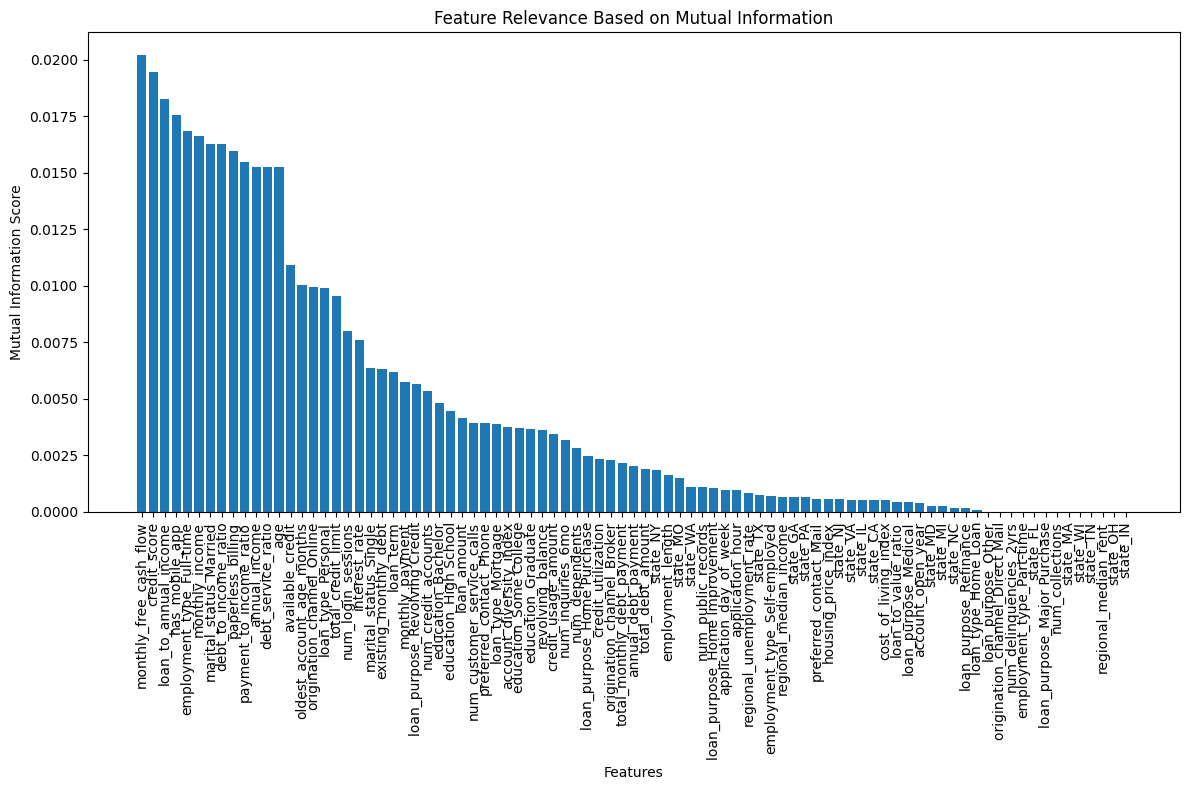

In [98]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

df_t = df.select_dtypes('number').copy()
fill_cols = ['num_delinquencies_2yrs', 'revolving_balance', 'employment_length']
df_t[fill_cols] = df_t[fill_cols].fillna(0.0)

X = df_t.drop("default", axis=1)
y = df_t["default"]


# ----- 2. Calculate Mutual Information scores -----
mi_scores = mutual_info_classif(X, y, random_state=42)

# Put into a DataFrame for easy handling
mi_df = pd.DataFrame({
    "feature": X.columns,
    "mi_score": mi_scores
}).sort_values(by="mi_score", ascending=False)

# ----- 3. Plot MI scores as bar chart -----
plt.figure(figsize=(12, 8))
plt.bar(mi_df["feature"], mi_df["mi_score"])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Feature Relevance Based on Mutual Information")
plt.tight_layout()
plt.show()

In [81]:
df_t[['num_delinquencies_2yrs', 'revolving_balance', 'employment_length']]

,num_delinquencies_2yrs,revolving_balance,employment_length
0,0.0,142213.1,2.2
1,0.0,75932.2,7.0
2,0.0,22314.6,0.8
3,0.0,8820.0,4.8
4,0.0,24253.6,5.2
...,...,...,...
89994,0.0,48680.4,3.7
89995,0.0,15833.0,4.2
89996,0.0,12242.7,1.5
89997,0.0,30516.6,3.5


In [92]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [96]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

In [97]:
df.select_dtypes('number')

,credit_score,num_credit_accounts,oldest_account_age_months,total_credit_limit,num_delinquencies_2yrs,num_inquiries_6mo,num_public_records,num_collections,account_diversity_index,regional_unemployment_rate,regional_median_income,regional_median_rent,housing_price_index,cost_of_living_index,loan_amount,loan_term,interest_rate,loan_to_value_ratio,monthly_income,existing_monthly_debt,monthly_payment,debt_to_income_ratio,debt_service_ratio,payment_to_income_ratio,credit_utilization,revolving_balance,credit_usage_amount,available_credit,total_monthly_debt_payment,annual_debt_payment,loan_to_annual_income,total_debt_amount,monthly_free_cash_flow,age,annual_income,employment_length,num_dependents,application_hour,application_day_of_week,account_open_year,num_login_sessions,num_customer_service_calls,has_mobile_app,paperless_billing,default,state_CA,state_FL,state_GA,state_IL,state_IN,state_MA,state_MD,state_MI,state_MO,state_NC,state_NJ,state_NY,state_OH,state_PA,state_TN,state_TX,state_VA,state_WA,state_WI,loan_type_Home Loan,loan_type_Mortgage,loan_type_Personal,loan_purpose_Home Improvement,loan_purpose_Home Purchase,loan_purpose_Major Purchase,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Refinance,loan_purpose_Revolving Credit,origination_channel_Broker,origination_channel_Direct Mail,origination_channel_Online,employment_type_Full-time,employment_type_Part-time,employment_type_Self-employed,education_Bachelor,education_Graduate,education_High School,education_Some College,marital_status_Married,marital_status_Single,preferred_contact_Mail,preferred_contact_Phone
0,696,14,273.6,169100.0,0.0,2,1,0,0.499,4.8,56000,1380.0,91.0,73.0,17700,36,12.50,0.000,5150.00,738.64,592.13,0.258,0.258402,0.115,0.841,142213.1,142213.1,26886.9,1330.77,15969.24,0.286408,159913.1,3819.230000,41,61800,2.2,2,5,6,2013,13,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0
1,659,13,42.0,78200.0,0.0,6,0,0,0.298,4.4,61000,1510.0,92.0,87.0,114000,180,6.83,0.774,2383.33,392.21,1013.86,0.590,0.589959,0.425,0.971,75932.2,75932.2,2267.8,1406.07,16872.84,3.986014,189932.2,977.260000,38,28600,7.0,0,4,2,2015,6,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
2,662,3,0.0,41400.0,0.0,2,0,0,0.174,3.9,74000,1920.0,125.0,103.0,9300,36,13.99,0.000,1725.00,204.07,317.81,0.303,0.302539,0.184,0.539,22314.6,22314.6,19085.4,521.88,6262.56,0.449275,31614.6,1203.120000,18,20700,0.8,0,10,3,2020,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1
3,676,8,108.0,60000.0,0.0,1,0,0,0.263,5.8,75000,1690.0,158.0,121.0,8700,48,13.26,0.000,2616.67,288.71,234.52,0.200,0.199961,0.090,0.147,8820.0,8820.0,51180.0,523.23,6278.76,0.277070,17520.0,2093.436667,27,31400,4.8,0,7,5,2010,4,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0
4,678,7,96.0,49700.0,0.0,1,0,0,0.298,5.8,78000,1700.0,152.0,127.0,7200,24,10.77,0.000,2050.00,248.77,334.81,0.285,0.284673,0.163,0.488,24253.6,24253.6,25446.4,583.58,7002.96,0.292683,31453.6,1466.420000,26,24600,5.2,0,1,2,2020,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89994,817,10,98.4,135600.0,0.0,1,0,0,0.285,5.8,75000,1830.0,168.0,138.0,11300,24,9.70,0.000,6025.00,2120.97,519.87,0.438,0.438314,0.086,0.359,48680.4,48680.4,86919.6,2640.84,31690.08,0.156293,59980.4,3384.160000,52,72300,3.7,1,13,5,2016,10,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
89995,745,9,105.6,44600.0,0.0,1,0,0,0.353,4.9,65000,1900.0,99.0,84.0,16500,36,11.67,0.000,